In [1]:
import nengo
import matplotlib.pyplot as plt
import numpy
import gym
import math
%matplotlib inline

# Network details

## Goal Directed/Model-Based

1. LatPFC Maintains a repository representing the environment. Repository of all states and actions.
   Receives cues from the environment and maintains it
   Receives SPE from preSMA and/or pIPS
   
2. LatOFC receives the repository and State Prediction Error from LatPFC and maintains a map of the environment. Something like an internal environment. Updates trainsition probabilities by SPE and updates reward values from dopamine errors. Infers current state based on cue received from LatPFC, previous action, previous state and previous action

3. mOFC uses the internal environment from map from LatOFC to do state space search. Receives dopamine errors and passes it to LatOFC to update the internal environment. Passes expected value of the next state after Depth Limited Search to vmPFC.

4. vmPFC maintains the expected value and passes it to the striatum. Updates expected value for that state from dopamne errors from the striatum and passes it to mOFC.

5. DMS represents expected value. Modulated by Dopamine. Passes it back to vmPFC

6. preSMA/pIPS compare expected state and actual and generates SPE. Passes SPE to latPFC.

## Habitual/Model-Free

1. latPFC maintains the repository of states and passes cue and the repository to dlPFC.

2. dlPFC maintains q_values. Constructs them using the repository from latPFC and dopamine errors from DLS. Uses the cue to decide which value to pass to the DLS.

3. DLS represents expected q_value. Modulated by Dopamine. Passes it back to dlPFC

In [2]:
env = gym.make("FrozenLake-v0")
state = env.reset()

[2017-09-07 15:54:39,617] Making new env: FrozenLake-v0


In [3]:
def to_discrete(vector):
    discrete = vector[0]*4 + vector[1]
    return discrete

def to_vector(discrete):
    vector = numpy.zeros((1, 2))
    vector[1] = discrete%4
    vector[0] = int(discrete/4)
    return vector


In [4]:
class latPFC:
    
    def __init__(self):
        self.state_repo = list()
        self.action_repo = list()
        
    def build_state_repo(self, env):
        for i in range(env.observation_space.n/4):
            for j in range(env.observation_space.n/4):
                self.state_repo.append([i, j])
        self.state_repo = numpy.array(self.state_repo)

    def bulid_action_repo(self, env):
        self.action_repo = numpy.array([[0, -1], [1, 0], [0, 1], [-1, 0]])
    
    def get_cue(self, cue):
        self.state = env.observation_space.sample()
    
    def calc_spe(self, exp_state, actual_state):
        if exp_state == actual_state:
            self.spe = 0
        else:
            self.spe = 1
        return spe
    

In [5]:
#spe is the state prediction error. 1 or 0. 1 is no error
#states is matrix of value for each state
#actions is actions in order "left, down, right, up"

class latOFC:
    def __init__(self, state_repo, action_repo, spe, cue):
        self.spe = spe
        self.spe_sum = 0
        self.count = 0
        self.states = numpy.zeros((len(state_repo)/4, len(state_repo)/4))
        self.states[0][1] = 1
        self.states[0][2] = 1
        self.actions = numpy.array([[0, -1], [1, 0], [0, 1], [-1, 0]])
        self.transition_prob = 1.0
        self.cue = cue

        
    def update_transition_prob(self, spe):
        self.count += 1
        self.spe_sum += spe
        self.transition_prob = float(self.spe_sum)/self.count
    
    @classmethod
    def transition(self, state, action, transition_prob):
        if numpy.random.rand() < transition_prob:
            temp = numpy.add(state, action)
            if temp[0] > 3 or temp[1] > 3 or temp[0] < 0 or temp[1] < 0:
                new_state = state
            else:
                new_state = temp
            
        else:
            rand_action = self.actions[env.action_space.sample()]
            temp = self.states[numpy.add(state, rand_action)]
            if temp[0] > 3 or temp[1] > 3 or temp[1] < 0 or temp[1] < 0:
                new_state = state
            else:
                new_state = temp
        return new_state                         
    
    def infer_state(self, cue, transition_prob, prev_state, prev_action):
        if self.count == 0:
            new_state = numpy.array([0, 0])
        else:    
            new_state = latOFC.transition(prev_state, prev_action, transition_prob)
        return new_state

       

In [6]:
class mOFC:
    #transition_prob, states and actions received from latPFC
    def __init__(self, transition_prob, states, actions):
        self.transition_prob = transition_prob
        self.states = states
        self.actions = actions

    
    #calculate value of current state using depth limited search
    def dls(self, curr_state, curr_depth, max_depth):
        value_list = list()
        if curr_depth == max_depth:
            return self.states[curr_state[0]][curr_state[1]]
        else:
            for i in self.actions:
                next_state = latOFC.transition(curr_state, i, self.transition_prob)
                #if list(next_state) in visited:
                 #   continue
                value = self.states[next_state[0]][next_state[1]] + 0.9*self.dls(next_state, curr_depth+1, max_depth)
                value_list.append(value)
            if value_list:
                average_value = numpy.mean(numpy.array(value_list))
        return average_value
    
    def value_of_action(self, curr_state):
        value_list = list()
        for i in self.actions:
            next_state = latOFC.transition(curr_state, i, self.transition_prob)
            value_list.append(self.dls(next_state, 0, 3))
        return value_list
        

In [7]:
class vmPFC:
    def __init__(self, actions, curr_state, value_list):
        self.curr_state = curr_state
        self.actions = actions
        self.value_list = value_list


In [8]:
class dlPFC:
    def __init__(self, state_repo, action_repo, cue):
        self.state_repo = state_repo
        self.action_repo = action_repo
        self.q_values = numpy.zeros((len(self.state_repo), len(self.action_repo)))
        self.cue = cue
        
    def q_update(self, cue, action, error):
        self.q_values[cue][action] = 0.5*self.q_values[cue][action] + 0.5*error
        
    def q_value_from_state(self, cue):
        return self.q_values[cue]

In [9]:
class dls:
    def __init__(self, q_value):
        self.q_value = q_value
    
    def error_modulation(self, action, error):
        self.q_value[action] = 0.5*self.q_value[action] + 0.5*error
        return self.q_value

In [10]:
a = latPFC()

In [11]:
a.build_state_repo(env)
a.bulid_action_repo(env)

In [13]:
b = latOFC(a.state_repo, a.action_repo, 0, 1)

In [14]:
c = mOFC(1.0, b.states, b.actions)

In [15]:
d = vmPFC(a.action_repo, numpy.array([1, 1]), c.value_of_action(numpy.array([1, 1])))

In [16]:
e = dlPFC(a.state_repo, a.action_repo, 2)
q_values = e.q_value_from_state(2)

In [17]:
f = dls(q_values)
print f.error_modulation(2, 1)

[ 0.   0.   0.5  0. ]


In [25]:
model = nengo.Network()
with model:
    a_state_repo_0 = nengo.networks.EnsembleArray(n_neurons=1000, n_ensembles=16, radius = 4)
    a_state_repo_1 = nengo.networks.EnsembleArray(n_neurons=1000, n_ensembles=16, radius = 4)
    a_state_0 = nengo.Node(a.state_repo[:, 0])
    a_state_1 = nengo.Node(a.state_repo[:, 1])    
    nengo.Connection(a_state_0, a_state_repo_0.input)
    nengo.Connection(a_state_1, a_state_repo_1.input)    
    
    a_action_repo_0 = nengo.networks.EnsembleArray(n_neurons=1000, n_ensembles=4, radius = 1)
    a_action_repo_1 = nengo.networks.EnsembleArray(n_neurons=1000, n_ensembles=4, radius = 1)
    a_action_0 = nengo.Node(a.action_repo[:, 0])
    a_action_1 = nengo.Node(a.action_repo[:, 1])    
    nengo.Connection(a_action_0, a_action_repo_0.input)
    nengo.Connection(a_action_1, a_action_repo_1.input)  
    
    new_state_0 = nengo.Ensemble(n_neurons=100, dimensions = 1, radius = 4)
    new_state_1 = nengo.Ensemble(n_neurons=100, dimensions = 1, radius = 4)
    
    nengo.Connection(a_action_repo_0.output[0], new_state_0)
    nengo.Connection(a_state_repo_0.output[3], new_state_0)

    nengo.Connection(a_action_repo_1.output[3], new_state_1)
    nengo.Connection(a_state_repo_1.output[1], new_state_1)
    
    probe_1 = nengo.Probe(new_state_0, synapse=0)
    probe_2 = nengo.Probe(new_state_1, synapse=0)

In [26]:
with nengo.Simulator(model) as sim:
    sim.run(0.01)


Building finished in 0:00:13.                                                   
Simulating finished in 0:00:01.                                                 


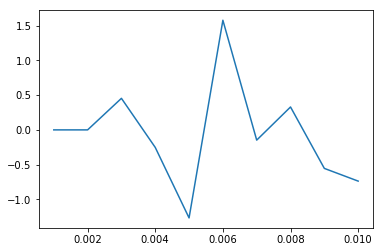

In [27]:
plt.plot(sim.trange(), sim.data[probe_1])

In [ ]:
print sim.data[probe_1]